## TPQ Final Project - System Testing 1.0


This study will look at short term bars in the SP500 e-mini (20 second bars) to determine the viability of using a moving average cross-over system with various parmeters to perform trade scalping. An SP emini scalper often trades for a 3 tick profit (.75 points) with a 6 tick risk (1.5 points).  As shown in my analysis of short-term SP e-mini swings, many swings are at least 1.0 to 1.5 points so looking for a scalp trader should be reasonable. 

This study will build upon Vves Hilpisch's Backtesting Jupyter notebook and related code. I have will using the following existing study capabilities:

- Short EMA (exponential moving average) cross Over Long EMA
- Start / Stop Time: Only allow trading for certain hours
- Wait Bars: The number of bars after a trade has ended before entering a new trade

I added additional study capabilities:
- Stop Loss: This study is applicable to commodities so it has a stop loss in actual points per contract (versus the stock related % of capital trading rules)
- Profit Target: The system will exit at a predetermined profit target (in points)

I also captured additional data:
- total closed profit per trade
- maximum open equity per trade

I added logic in the study to:
1) Run a single set of parameters, display a summary, and export all swings to excel. 
2) Run a multitude of settings and sorting the results (a) by total closed profit and (b) total open equity

Additional graphs are created based on the study output.

The theory is that the user can run the multitude of parameter settings and then determine which individual studies to analyze in more detail. The study can read in any intraday commodity data.

## The Data

In [1]:
# Import Libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11,4)})
from datetime import datetime

# current date and time
now = datetime.now()
print(now)

2019-11-19 20:07:02.360505


In [2]:
# Reading ES 03 19 - Jan 1 - 18, 2019
# 
df = pd.read_csv(r"C:\Users\522147\Desktop\ES_03_19_2019_01_to_18_20secV2.csv", 
                    index_col=0, parse_dates=True, sep=",")
df.head(10)

,open,high,low,close
Date_Time,,,,
2019-01-01 23:00:00,2493.00,2493.00,2492.75,2493.00
2019-01-01 23:00:20,2493.25,2493.50,2493.25,2493.50
2019-01-01 23:00:40,2493.25,2493.25,2493.00,2493.25
2019-01-01 23:01:00,2493.50,2493.50,2493.25,2493.25
2019-01-01 23:01:20,2493.25,2493.50,2493.25,2493.25
2019-01-01 23:01:40,2493.25,2493.25,2492.75,2492.75
2019-01-01 23:02:00,2492.75,2492.75,2492.75,2492.75
2019-01-01 23:02:20,2492.50,2492.50,2492.00,2492.00
2019-01-01 23:02:40,2492.00,2492.00,2491.75,2491.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72361 entries, 2019-01-01 23:00:00 to 2019-01-18 17:00:00
Data columns (total 4 columns):
open     51953 non-null float64
high     51953 non-null float64
low      51953 non-null float64
close    51953 non-null float64
dtypes: float64(4)
memory usage: 2.8 MB


In [4]:
df.tail(10)

,open,high,low,close
Date_Time,,,,
2019-01-18 16:57:00,2676.25,2676.50,2676.25,2676.50
2019-01-18 16:57:20,2676.25,2676.50,2676.00,2676.25
2019-01-18 16:57:40,2676.00,2676.75,2676.00,2676.50
2019-01-18 16:58:00,2676.50,2676.75,2676.50,2676.75
2019-01-18 16:58:20,2676.50,2677.25,2676.50,2676.75
2019-01-18 16:58:40,2676.75,2677.25,2676.25,2676.75
2019-01-18 16:59:00,2676.75,2677.50,2676.75,2677.25
2019-01-18 16:59:20,2677.00,2677.00,2676.25,2676.25
2019-01-18 16:59:40,2676.25,2677.25,2676.25,2677.00


Setting EMAs for the initial chart

In [10]:
df['21ema'] = pd.Series.ewm(df['close'], span=21).mean()
df['55ema'] = pd.Series.ewm(df['close'], span=55).mean()

## data - subset data copy for testing 

In [12]:
#
# Copying subset of data for testing as the system can run a long time 
#
data = df.iloc[-11000:].copy() 

In [13]:
data.head()

,open,high,low,close,21ema,55ema
Date_Time,,,,,,
2019-01-16 03:53:40,2614.50,2614.50,2614.25,2614.25,2614.344078,2614.128876
2019-01-16 03:54:00,2614.25,2614.50,2614.25,2614.25,2614.335525,2614.133202
2019-01-16 03:54:20,2614.25,2614.25,2614.00,2614.25,2614.327750,2614.137373
2019-01-16 03:54:40,2614.25,2614.50,2614.25,2614.50,2614.343409,2614.150324
2019-01-16 03:55:00,2614.50,2614.75,2614.25,2614.25,2614.334917,2614.153884


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11000 entries, 2019-01-16 03:53:40 to 2019-01-18 17:00:00
Data columns (total 6 columns):
open     10369 non-null float64
high     10369 non-null float64
low      10369 non-null float64
close    10369 non-null float64
21ema    11000 non-null float64
55ema    11000 non-null float64
dtypes: float64(6)
memory usage: 601.6 KB


In [15]:
# Intraday SP500 emini data can have null data during daily outages (typically 4 - 5pm EST, Sunday nights, and low overnight activity periods)
# Dropping these NaNs 
#
data.dropna(subset=['open'],inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10369 entries, 2019-01-16 03:53:40 to 2019-01-18 17:00:00
Data columns (total 6 columns):
open     10369 non-null float64
high     10369 non-null float64
low      10369 non-null float64
close    10369 non-null float64
21ema    10369 non-null float64
55ema    10369 non-null float64
dtypes: float64(6)
memory usage: 567.1 KB


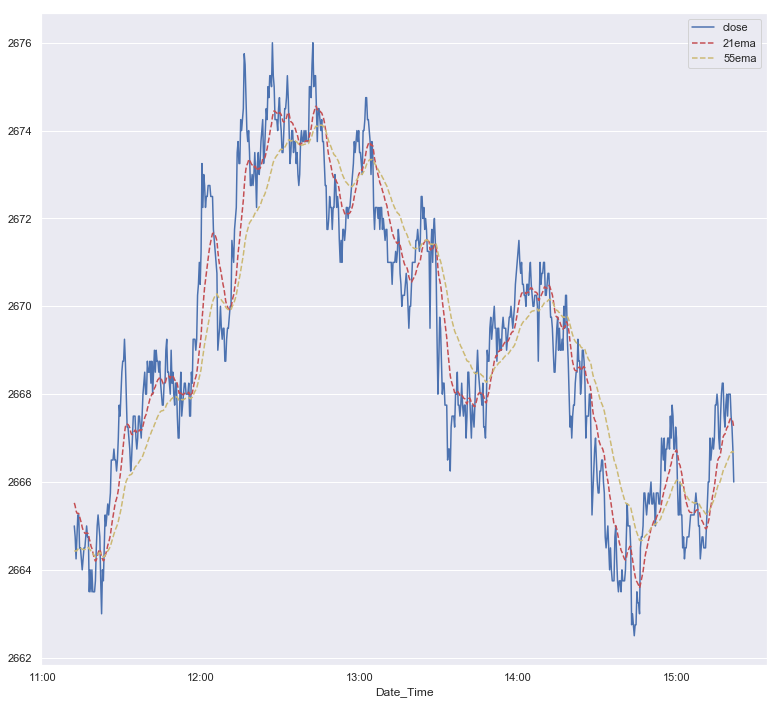

In [17]:
data[['close', '21ema', '55ema']].iloc[-1000:-250].plot(figsize=(13, 12), grid=True,
                                           style=['b', 'r--', 'y--']);

# Moving Average Cross-over Study

Lines 319 - 324 contain the adjustable parameters
- Single study or multiple study runs
- Parameters
    - Short and Long EMAs
    - Profit Target
    - Stop Loss
    - Wait time between trades
    - Hour of days allow for trading
    
Note: This study enters on the close once the short EMA crosses over the long EMA. This study only allow 1 trade per direction (long or short)
and it will only enter a new trade once the EMA crosses over in the opposite direction (i.e., once you have a long, the next trade can only be a short)

In [19]:
# 
# Moving Average Cross Over Study
#
class FinancialData:
    def __init__(self, instrument, start, end, granularity):
        self.instrument = instrument
        self.start = start
        self.end = end
        self.granularity = granularity
        self.filename = 'oanda_{}_{}_{}_{}.csv'.format(
                    instrument, start, end, granularity)
        self.prepare_data()

    def prepare_data(self):
        self.end = end 
        self.data = data.iloc[:].copy()

class BacktestingBase(FinancialData):
    def __init__(self, instrument, start, end, granularity,amount, verbose=True):
        super(BacktestingBase, self).__init__(instrument, start,end, granularity)
        self.initial_amount = amount  # initial cash
        self.amount = amount  # current cash balance
        self.cum_pts = 0 # cumulative closed strategy points
        self.cum_oe_pts = 0 # cumulative open equity points
        self.size = 1  # position size (Oanda units)
        self.leverage = 1 # leverage of account
        self.position = 0  # current position
        self.units = 0  # number of units in position
        self.trades = 0  # number of trades
        self.wait = 0  # waiting periods after stop loss
        self.sls = 0  # number of stop losses
        self.verbose = verbose
        self.entry_price = 0 # entry price

    def get_date_price(self, bar):
        date = str(self.data.index[bar])
        high = self.data['high'].iloc[bar]   # changed bid to close
        low = self.data['low'].iloc[bar]   # changed ask to close
        close = self.data['close'].iloc[bar]   # changed ask to close
        return date, high, low, close
            
    def print_balance(self, bar):
        date, high, low, close = self.get_date_price(bar)
        print('{} | current cash balance is {:.2f}'.format(date, self.amount))

    def print_net_wealth(self, bar):
        date, high, low, close = self.get_date_price(bar)
        #price = bid if self.position == 1 else ask
        price = close
        nw = self.amount + self.units * price / self.leverage
        print('{} | current  net wealth  is {:.2f}'.format(date, nw))

    def place_buy_order(self, bar, units=None,  amount=None):
        date, high, low, close = self.get_date_price(bar)
        if units is None:
            units = 1        # always assuming buying 1 contract
        self.amount -= 0   #units * ask / self.leverage
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'Trade# {self.trades} Buy: {date} {units} contracts for {close:.2f} Stoploss @ {self.buy_sl}')
                                    
    def exit_long(self, bar, high, low, close, date, exit_price, units=None,  amount=None):
        if units is None:
            units = 1        # always assuming buying 1 contract
        self.amount -= 0   #units * ask / self.leverage
        self.cum_pts += exit_price - self.buy_pr
        self.cum_oe_pts += self.buy_oe
        if self.verbose:
            print(f'Buy EXIT: {date} Buy Pr {self.buy_pr} Buy Bar: {self.buy_pr_bar} High: {high} OE: {self.buy_oe} OE Bar# {self.buy_oe_bar} \
Exit Pr: {exit_price} Closed Pts: {exit_price - self.buy_pr} Cum_Pts: {self.cum_pts} Cum_OE_Pts: {self.cum_oe_pts}')
        all_swing_list.append({'Date_Time':date, 'Trade_num':{self.trades},'Trade':'Buy','ent_pr':self.buy_pr, 'high_lo':'High', 'oe':self.buy_oe,'oe_bar':self.buy_oe_bar,'exit_pr':exit_price,'closed_pts':round(exit_price - self.buy_pr,2), \
                                   'cum_pts':round(self.cum_pts,2),'cum_oe_pts':round(self.cum_oe_pts,2)})

    def place_sell_order(self, bar, units=None, amount=None):
        date, high, low, close = self.get_date_price(bar)
        if units is None:
            units = 1 
        self.amount += 0  # units * bid / self.leverage
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'Trade# {self.trades}   SELL: {date} {units} contracts @ {close:.2f} Stoploss @ {self.sell_sl}')
            

    def exit_short(self, bar, high,low,close, date, exit_price, units=None,  amount=None):
        #date, high, low, close = self.get_date_price(bar)
        if units is None:
            units = 1        # always assuming buying 1 contract
        self.amount -= 0   #units * ask / self.leverage
        self.cum_pts += self.sell_pr - exit_price  
        self.cum_oe_pts += self.sell_oe
        if self.verbose:
            print(f'  -- Sell EXIT: {date} Sell Pr {self.sell_pr} Sell Bar: {self.sell_pr_bar} Low: {low} OE: {self.sell_oe} OE Bar# {self.sell_oe_bar} \
Exit Pr: {exit_price} Closed Pts: {self.sell_pr - exit_price} Cum_Pts: {self.cum_pts} Cum_OE_Pts: {self.cum_oe_pts}')
        all_swing_list.append({'Date_Time':date, 'Trade_num':{self.trades},'Trade':'Sell', 'ent_pr':self.sell_pr,'high_lo':'Low', 'oe':self.sell_oe,'oe_bar':self.sell_oe_bar,'exit_pr':exit_price,'closed_pts':round(self.sell_pr - exit_price,2), \
                                   'cum_pts':round(self.cum_pts,2),'cum_oe_pts':round(self.cum_oe_pts,2)})
    ##-----

            
    def close_out(self, bar):
        date, high, low, close = self.get_date_price(bar)
        price = close # bid if self.position == 1 else ask
        # close out remaining positions
        self.amount += (self.units * price) * self.position / self.leverage
        self.units -= self.units
        #self.trades += 1
        if self.print_summary:
            print('\n{} | *** CLOSING OUT ***'.format(date))
            print(74 * '=')
            print('{} | number of trades: {}'.format(date, self.trades))
            print('{} | number of stops hit: {}'.format(date, self.sls))
            print('{} | $Profit Targets: Buys PTs hit: {} | Sell PTs hit: {}'.format(date, self.bpt, self.spt))
            print('{} | Total CLosed Points: {} Total Open Equity: {}'.format(date, self.cum_pts, self.cum_oe_pts,2))
            print(74 * '=')
        strategy_out_list.append({'date_time':date, 'parm_sma':{self.SMA},'parm_lma':{self.LMA},'parm_prof_target':{self.prof_target},'parm_stop_loss':{self.stop_loss},'parm_wait_bars':{self.max_wait},\
                                  'tot_trades':{self.trades},'tot_stopped_out':{self.sls},'buy_prof_hit':{self.bpt},'sell_prof_hit':{self.spt},'cum_closed_pts':round(self.cum_pts,2),'cum_oe_pts':round(self.cum_oe_pts,2)})
        self.position = 0
        self.trades = 0
        self.cum_pts = 0
        self.cum_oe_pts = 0
        self.bpt = 0
        self.spt = 0
        self.sls = 0
        

#
#  Code from sma_ewma_backtesting_window.py
#
class SmaEwmaBacktesterWindow(BacktestingBase):

    def prepare_statistics(self):
        self.data['short_ewma'] = pd.Series.ewm(self.data['close'], span=self.SMA).mean()
        self.data['long_ewma'] = pd.Series.ewm(self.data['close'], span=self.LMA).mean() 

    def run_strategy(self, SMA, LMA, alpha, size, leverage, stop_loss, prof_target, max_wait,start_time, end_time, print_summary,print_swings_xls):
        self.SMA = SMA
        self.LMA = LMA
        self.alpha = alpha
        self.size = size
        self.leverage = leverage
        self.stop_loss = stop_loss
        self.buy_pr = 0
        self.buy_pr_bar = 0
        self.buy_date = 0
        self.buy_sl = 0
        self.buy_sl_bar = 0
        self.buy_oe = 0
        self.buy_oe_bar = 0
        self.buy_ex = 0
        self.buy_ex_bar = 0
        self.sell_pr = 0
        self.sell_pr_bar = 0
        self.sell_date = 0
        self.sell_sl = 0
        self.sell_sl_bar = 0
        self.sell_oe = 0
        self.sell_oe_bar = 0
        self.max_wait = max_wait
        self.start_time = start_time
        self.end_time = end_time
        self.prof_target = prof_target
        self.print_summary = print_summary
        self.print_swings_xls = print_swings_xls
        self.position = 0
        self.trades = 0
        self.wait = 0
        self.sls = 0
        self.units = 0
        self.bpt = 0
        self.spt = 0
        self.amount = self.initial_amount
        self.next_trade = 1
        self.prepare_statistics()

        if self.print_summary:
            print('*** RUNNING STRATEGY ***')
            print('SMA = {} | LMA = {} | alpha = {:.3f}'.format(self.SMA, self.LMA, self.alpha))
            print('start {} | end {} | bar {}'.format(
                self.start, self.end, self.granularity))
            print('size = {} | leverage = {} | stop loss {} | wait bars {}'.format(
                self.size, self.leverage, self.stop_loss, self.max_wait))
            print('start = {} | end = {} | Profit Target = {}'.format(self.start_time, self.end_time, self.prof_target))

        for bar in range(self.SMA, len(self.data)):              # data - for loop
            date, high, low, close = self.get_date_price(bar)
            ts = pd.Timestamp(date)
            trading = (ts.hour >= self.start_time) and (ts.hour <= self.end_time)
            if not trading:
                if self.position != 0:
                    if self.verbose:
                        print('\n{} | *** EOD CLOSING ***'.format(date))
                    if self.position == 1:
                        self.exit_long(bar,high,low,close, date=self.buy_date,exit_price=self.buy_sl,units=-self.units) 
                    else:
                        self.exit_short(bar,high,low,close, date=self.sell_date,exit_price=self.sell_sl,units=self.units)
                    self.position = 0

            if self.wait > 0: self.wait -= 1
            elif self.position in [-1, 1] and trading:
                price = low if self.position == 1 else high     # use low for calc stop loss on buys, high for stop loss on sells
                if self.position == 1:                          # calculating stop loss - if long
                    if high - self.buy_pr > self.buy_oe:    # if new OE high, update OE pts and # of bars in trade
                        self.buy_oe = high - self.buy_pr
                        self.buy_oe_bar = bar - self.buy_pr_bar
                        if self.verbose:
                            print(f'Buy: - Trade # {self.trades} new OE: {date} Buy Pr {self.buy_pr} Buy Bar: {self.buy_pr_bar} High: {high} OE: {self.buy_oe} OE Bar# {self.buy_oe_bar}')
                    if high - self.buy_pr >= self.prof_target:        # exit on Buy profit target
                        self.buy_oe = self.prof_target
                        self.buy_oe_bar = bar - self.buy_pr_bar
                        self.buy_ex = self.buy_pr + self.prof_target
                        if self.verbose:
                            print(f'---- Buy: Trade # {self.trades} $PT exit: {date} Buy Pr {self.buy_pr} Buy Bar: {self.buy_pr_bar} High: {high} PT: {self.prof_target} OE Bar# {self.buy_oe_bar}')
                        self.exit_long(bar,high,low,close, date=self.buy_date,exit_price=(self.buy_ex),units=-self.units) 
                        self.position = 0
                        self.wait = self.max_wait
                        self.bpt +=1
                        # calc Buy Open Equity
                    if low <= self.buy_sl:                      # check buy stop loss
                        if self.verbose:
                            print(f'Date: {date} Trade # {self.trades} | *** BUY STOP LOSS$ *** Buy_SL: {self.buy_sl} Low: {low}')    
                        self.exit_long(bar,high,low,close, date=self.buy_date,exit_price=self.buy_sl,units=-self.units) 
                        self.position = 0
                        self.wait = self.max_wait
                        self.sls +=1
                else:                                           # calculating stop loss = if short
                    # calc Sell Open Equity
                    if self.sell_pr - low > self.sell_oe:    # if new OE high, update OE pts and # of bars in trade
                        self.sell_oe = self.sell_pr - low
                        self.sell_oe_bar = bar - self.sell_pr_bar
                        if self.verbose:
                            print(f'   Sell: Trade # {self.trades} - new OE: {date} Sell Pr {self.sell_pr} Sell Bar: {self.sell_pr_bar} Low: {low} OE: {self.sell_oe} OE Bar# {self.sell_oe_bar}')
                    if self.sell_pr - low >= self.prof_target:        # exit on sell profit target
                        self.sell_oe = self.prof_target
                        self.sell_oe_bar = bar - self.buy_pr_bar
                        self.sell_ex = self.sell_pr - self.prof_target
                        if self.verbose:
                            print(f' -- Sell: Trade # {self.trades} $PT exit: {date} Sell Pr {self.sell_pr} Sell Bar: {self.sell_pr_bar} Low: {low} PT: {self.prof_target} OE Bar# {self.sell_oe_bar}')
                        self.exit_short(bar,high,low,close, date=self.sell_date,exit_price=self.sell_ex,units=self.units)
                        self.position = 0
                        self.wait = self.max_wait
                        self.spt +=1
                    if high >= self.sell_sl:
                        if self.verbose:
                            print(f'Date: {date} Trade # {self.trades}  | *** Sell STOP LOSS$ *** Sell_SL: {self.sell_sl} High: {high}')    
                        self.exit_short(bar,high,low,close, date=self.sell_date,exit_price=self.sell_sl,units=self.units)
                        self.position = 0
                        self.wait = self.max_wait
                        self.sls +=1

                
            if self.position in [0, -1] and self.wait == 0 and trading:        # if flat or short, go long if SMA > EMA
                if self.data['short_ewma'].iloc[bar] > self.data['long_ewma'].iloc[bar] and self.next_trade == 1:
                    if self.verbose:
                        print('\n{} | *** PLACING BUY ORDER ***'.format(date))
                    if self.position == -1:
                        self.exit_short(bar,high,low,close, date=self.sell_date,exit_price=close,units=self.units)      # if short, exit short before reversing to long
                    self.entry_price = close
                    self.buy_date = date
                    self.buy_pr = close
                    self.buy_pr_bar = bar
                    self.buy_oe = 0
                    self.buy_oe_bar = 0
                    self.buy_sl = self.entry_price - self.stop_loss
                    self.place_buy_order(bar, amount=self.size)                
                    self.position = 1
                    self.next_trade = -1

            if self.position in [0, 1] and self.wait == 0 and trading:      # if flat or long, go short if SMA < EMA
                if self.data['short_ewma'].iloc[bar] < self.data['long_ewma'].iloc[bar] and self.next_trade == -1:
                    if self.verbose:
                        print('\n{} | *** PLACING SELL ORDER ***'.format(date))
                    if self.position == 1:
                        self.exit_long(bar,high,low,close, date=self.buy_date,exit_price=close,units=-self.units)           # if long, exit long before reversing to short
                    self.entry_price = close
                    self.sell_date = date
                    self.sell_pr = close
                    self.sell_pr_bar = bar
                    self.sell_oe = 0
                    self.sell_oe_bar = 0
                    self.sell_sl = self.entry_price + self.stop_loss
                    self.place_sell_order(bar, amount=self.size)                          # sell order             
                    self.position = -1
                    self.next_trade = 1

        self.close_out(bar)
        
        if self.print_swings_xls:
            test_df = pd.DataFrame(all_swing_list)
            test_df.set_index('Date_Time',inplace=True)
            neworder = ['Trade_num','Trade','ent_pr','exit_pr','closed_pts','cum_pts','oe','cum_oe_pts','high_lo','oe_bar']
            test_df=test_df.reindex(columns=neworder)
            test_df.to_excel("tpq_all_swings_breakouts_list.xlsx")  # export to excel
#-----  End of System Code ------------------------------------------------------------------------------------------------
        
#-----  Beg of Execution Code ---------------------------------------------------------------------------------------------        
all_swing_list = []      # exporting swings from individual strategy runs
strategy_out_list = []   # exporting overal strategy results


if __name__ == '__main__':
    instrument = 'EUR_GBP'
    start = '2018-08-01'
    end = '2018-10-01'
    granularity = 'M10'

#     
sma = SmaEwmaBacktesterWindow(instrument, start, end, granularity,10000, verbose=False)


# System parameters
# (Short EMA, Long EMA, alpha,  size, leverage, stop_loss, prof_target, max_wait, start_time, end_time):
# (       21,       55,  0.03, 20000,       20,         3,           8,        5,          8,       15):
#
# Set "run_single_strategy" = True and Update the parameters to run 1 strategy
# print_swings_xls = True creates an excel file of all swings in the same directory as the jupyter notebook. 
# This excel file is used below in 2 charts showing each trade's closed profits vs open equity
#
run_single_strategy = False   #<<<<<<<  Set to True to run a single strategy

if run_single_strategy:
    sma.run_strategy(8, 34, 0.03, 200000, 20, 4, 10, 5, 8, 15,print_summary = True, print_swings_xls=True)
#
#
#  Set "run_multiples_strategies" to true and update strategy parameter lists to process the strategies and output to a sorted dataframe
#  Adjust the 5 parameters below as necessary (s_ema, l_ema, stop_pts, prof_target, wait_bars)
# 
run_multiple_strategies = True  #<<<<<<< Set to True to run multiple strategies

s_ema = [8, 13, 21]     # 8,13,21:       Short Moving Averages (Note - Short EMAs should be distinct and less then the smallest Long EMA)
l_ema = [34,55]         # 34, 55:        Long Moving Averages
stop_pts  = [2,3,4]     # 1,2,3,4,5      Stop (in points) for each trade
prof_targ = [1,3,5,10]  # 1,2,3,4,5,10   Profit Target (in points) for each trade. A large profit target (like 10+ points) probably won't be hit
wait_bars = [0,5,10]    # 0, 5, 10, 15   Number of bars before the next trade can be taken

#
# Do not modify the python code below this line
# 

total_runs = len(s_ema) * len(l_ema) * len(stop_pts) * len(prof_targ) * len(wait_bars)
ctr = 0

if run_multiple_strategies:
    print(" {} Strategy Runs started......".format(total_runs)) 
    print(" Currently on Strategy # ......") 
    for a in s_ema:
        for b in l_ema:
            for c in stop_pts:
                for d in prof_targ:
                    for e in wait_bars:
                        ctr += 1
                        sma.run_strategy(a, b, 0.03, 200000, 20, c, d, e, 8, 15, print_summary = False, print_swings_xls=False)
                        print('{}'.format(ctr),end=", ")
    print("")
    print(" ----  Strategy Runs have completed !")
    
    strat_df = pd.DataFrame(strategy_out_list)
    strat_df.set_index('date_time',inplace=True)
    neworder = ['cum_closed_pts', 'cum_oe_pts', 'tot_trades','buy_prof_hit','sell_prof_hit','tot_stopped_out','parm_sma','parm_lma','parm_stop_loss', 'parm_prof_target', 'parm_wait_bars']
    strat_df=strat_df.reindex(columns=neworder)

            
            


 216 Strategy Runs started......
 Currently on Strategy # ......
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209

### Sort the trading strategy results based upon the Maximum Closed Points of the strategy
### Rerun a single strategy (above) with the specific parameters to analysis an individual strategy

In [20]:
strat_df.sort_values('cum_closed_pts', ascending=False).head(20)

,cum_closed_pts,cum_oe_pts,tot_trades,buy_prof_hit,sell_prof_hit,tot_stopped_out,parm_sma,parm_lma,parm_stop_loss,parm_prof_target,parm_wait_bars
date_time,,,,,,,,,,,
2019-01-18 17:00:00,20.50,74.75,{99},{35},{28},{2},{21},{55},{3},{1},{5}
2019-01-18 17:00:00,19.50,82.75,{103},{41},{28},{6},{13},{55},{3},{1},{5}
2019-01-18 17:00:00,18.75,94.00,{123},{45},{34},{18},{13},{34},{2},{1},{10}
2019-01-18 17:00:00,17.75,74.00,{99},{34},{28},{2},{21},{55},{3},{1},{0}
2019-01-18 17:00:00,17.75,81.25,{103},{41},{27},{6},{13},{55},{3},{1},{10}
2019-01-18 17:00:00,17.50,74.00,{99},{34},{28},{0},{21},{55},{4},{1},{5}
2019-01-18 17:00:00,17.50,74.00,{99},{34},{28},{0},{21},{55},{4},{1},{0}
2019-01-18 17:00:00,15.50,93.50,{133},{44},{35},{14},{8},{55},{2},{1},{10}
2019-01-18 17:00:00,14.75,97.75,{139},{47},{36},{4},{8},{55},{3},{1},{10}


### Sort the trading strategy results based upon the Maximum Open Equity of the strategy
### Rerun a single strategy (above) with the specific parameters to analysis an individual strategy

In [21]:
strat_df.sort_values('cum_oe_pts', ascending=False).head(20)

,cum_closed_pts,cum_oe_pts,tot_trades,buy_prof_hit,sell_prof_hit,tot_stopped_out,parm_sma,parm_lma,parm_stop_loss,parm_prof_target,parm_wait_bars
date_time,,,,,,,,,,,
2019-01-18 17:00:00,-33.50,326.25,{185},{4},{1},{3},{8},{34},{4},{10},{5}
2019-01-18 17:00:00,-42.25,325.50,{185},{3},{1},{3},{8},{34},{4},{10},{10}
2019-01-18 17:00:00,-35.75,324.00,{185},{4},{1},{3},{8},{34},{4},{10},{0}
2019-01-18 17:00:00,-28.50,324.00,{185},{4},{1},{4},{8},{34},{3},{10},{5}
2019-01-18 17:00:00,-30.75,324.00,{185},{4},{1},{6},{8},{34},{3},{10},{0}
2019-01-18 17:00:00,-39.25,310.50,{185},{4},{0},{29},{8},{34},{2},{10},{0}
2019-01-18 17:00:00,-33.25,309.50,{181},{3},{1},{5},{8},{34},{3},{10},{10}
2019-01-18 17:00:00,-49.75,286.75,{131},{3},{0},{5},{13},{34},{4},{10},{10}
2019-01-18 17:00:00,-43.25,286.00,{179},{4},{0},{29},{8},{34},{2},{10},{5}


## Take parameters from a specific trading scenario result above and run the individual study. Set print_swings_xls=True to create excel file output
## The cells below read in the excel swing file for an individual strategy and output analysis of the swings

In [22]:
df_xls_in = pd.read_excel(r"C:\Users\522147\Documents\1 Python\1Yves - Python for Finance\Final TPQ project\tpq_all_swings_breakouts_list.xlsx",index_col=0, parse_dates=True)
df_xls_in.tail(20)

,Trade_num,Trade,ent_pr,exit_pr,closed_pts,cum_pts,oe,cum_oe_pts,high_lo,oe_bar
Date_Time,,,,,,,,,,
2019-01-18 13:26:40,{166},Sell,2669.50,2671.75,-2.25,-23.50,0.00,287.50,Low,0
2019-01-18 13:28:00,{167},Buy,2671.75,2670.75,-1.00,-24.50,0.50,288.00,High,1
2019-01-18 13:29:00,{168},Sell,2670.75,2669.00,1.75,-22.75,4.75,292.75,Low,14
2019-01-18 13:44:40,{169},Buy,2669.00,2667.75,-1.25,-24.00,0.00,292.75,High,0
2019-01-18 13:46:20,{170},Sell,2667.75,2668.25,-0.50,-24.50,0.00,292.75,Low,0
2019-01-18 13:46:40,{171},Buy,2668.25,2667.25,-1.00,-25.50,0.25,293.00,High,1
2019-01-18 13:47:00,{172},Sell,2667.25,2668.75,-1.50,-27.00,0.50,293.50,Low,2
2019-01-18 13:48:40,{173},Buy,2668.75,2668.75,0.00,-27.00,2.75,296.25,High,34
2019-01-18 14:07:40,{174},Sell,2668.75,2671.00,-2.25,-29.25,0.00,296.25,Low,0


In [23]:
# add pts_delta field to excel file listing swings
#
df_xls_in['pts_delta'] = df_xls_in['oe'] - df_xls_in['closed_pts']

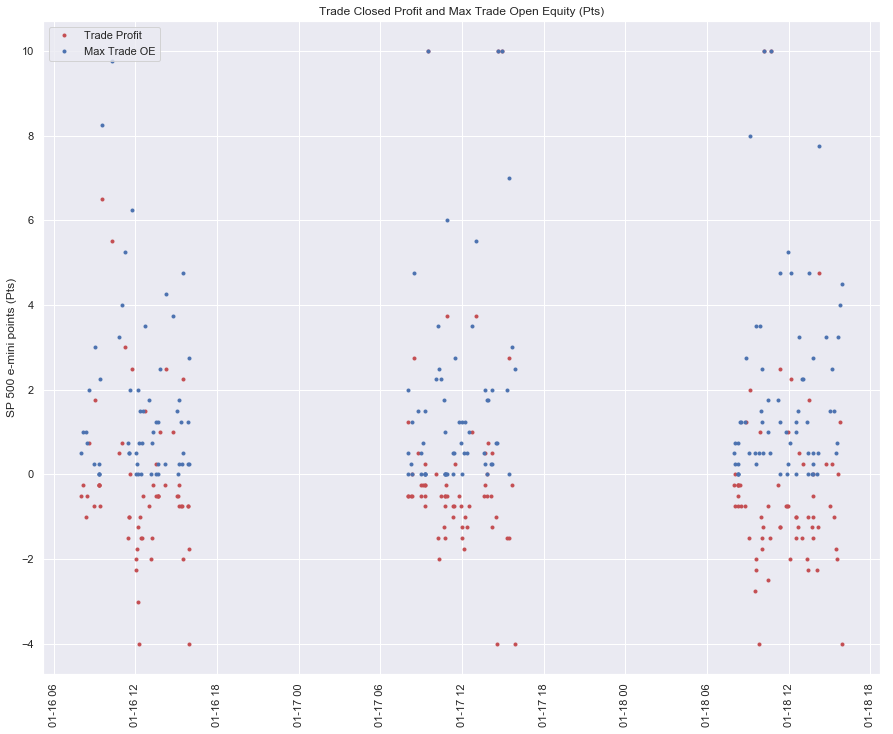

In [24]:
# Plotting Trade Closed Profit and Max Trade Open Equity (Pts) for an individual study
#
fig, ax = plt.subplots(figsize = (15,12))
ax.plot(df_xls_in['closed_pts'],marker='.', linestyle='-', linewidth=0, label='Trade Profit',c='r')
ax.plot(df_xls_in['oe'],marker='.', linestyle='-', linewidth=0, label='Max Trade OE',c='b')
plt.xticks(rotation=90)
ax.set_ylabel('SP 500 e-mini points (Pts)')
ax.set_title('Trade Closed Profit and Max Trade Open Equity (Pts)')
ax.legend();

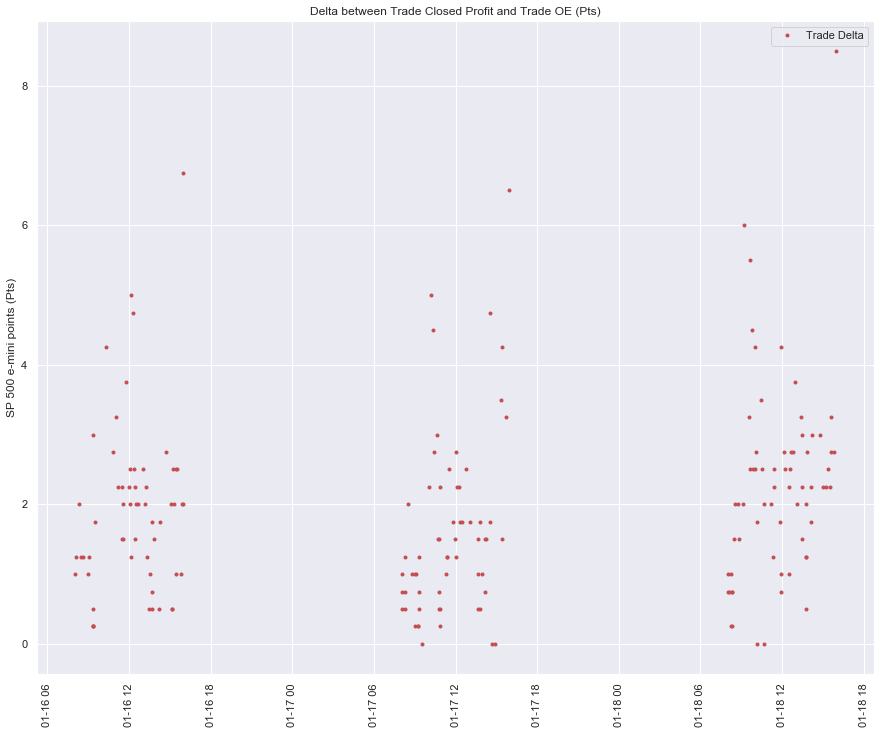

In [25]:
# Plotting Delta between the maximum open equity of each trade and the maximum open equity of each trade 
# 
# 
fig, ax = plt.subplots(figsize = (15,12))
ax.plot(df_xls_in['pts_delta'],marker='.', linestyle='-', linewidth=0, label='Trade Delta',c='r')
plt.xticks(rotation=90)
ax.set_ylabel('SP 500 e-mini points (Pts)')
ax.set_title('Delta between Trade Closed Profit and Trade OE (Pts)')
ax.legend();

In [26]:
# Histrogram on 'pts_delta'  (trade open equity - trade closed profit)
#
df_xls_in['pts_delta'].describe(percentiles=[.1, .2, .3, .4, .5, .75, .80, .90])

count    185.000000
mean       1.944595
std        1.354581
min        0.000000
10%        0.500000
20%        0.750000
30%        1.250000
40%        1.500000
50%        1.750000
75%        2.500000
80%        2.750000
90%        3.400000
max        8.500000
Name: pts_delta, dtype: float64

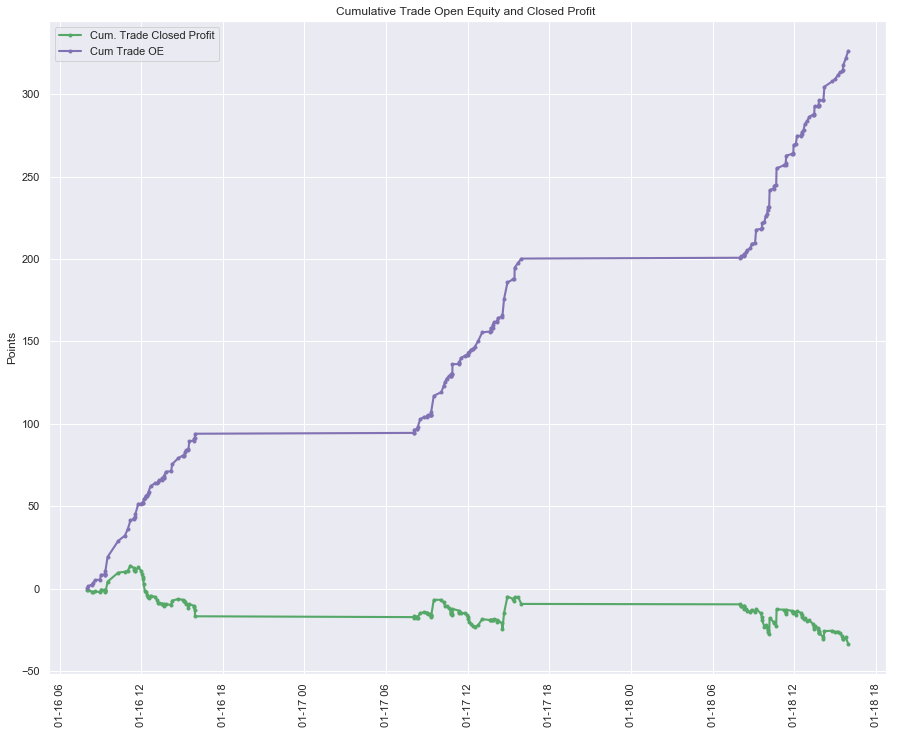

In [28]:
# PLotting Cumulative Trdae Open Equity and Closed Profit 
#
fig, ax = plt.subplots(figsize = (15,12))
ax.plot(df_xls_in['cum_pts'],marker='.', linestyle='-', linewidth=2.1, label='Cum. Trade Closed Profit',c='g')
ax.plot(df_xls_in['cum_oe_pts'],marker='.', linestyle='-', linewidth=2.1, label='Cum Trade OE',c='m')
plt.xticks(rotation=90)
ax.set_ylabel('Points')
ax.set_title('Cumulative Trade Open Equity and Closed Profit ')
ax.legend();

# End of Code

#### Study Summary. 

As highlighted above, the studies with the highest closed profit have the smallest (1 pt) profit target. Unfortunuately, they low total profit (in points) would be negative if commission costs were included in the study. The Short and Long EMAs were inconsistent however since the study enters on a close after the short EMA crosses over the long EMA, the key is to realize the quick profit before the 2 or 3 point stop is hit.

The comparison of the studies with the most open equity shows a different picture. First, wider stops (4 points) and a larger profit target (10 pts) lead to 326 points of open profit on 184 trades.  The net profit (before slippage and commission) was a negative 33.5 points.  

There are several potential "next steps" to be reviewed.
- Improving the entry - waiting for a limit entry (entering market close after EMA crosses is often a bad trade entry)
- Improving the exit - an additional trailing stop (% of open equity after X bars - similar to a parabolic stop) should improve the exits on winning trades
- Reducing the number of trades - in tight sideways markets, the EMAs cross every few bars and the study is basically buying the highs and selling the lows

While this study did not find a profitable way to scalp the SP e-minis, it did provide a framework for the analysis and it will lead to additional studies
on the items I summarized above